### Object detection and segmentation using pytorch
This example will use the Penn-Fudan dataset to demonstrate object detection and segmentation using pytorch.

#### Prepare the dataset

In [1]:
#download the zipped dataset and decompress it on data folder
## download if not present
import os
if not os.path.exists('./data/pennfudan'):
    !mkdir data/pennfudan/
    !wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip -P data/pennfudan/
    #unzip the dataset
    !unzip data/pennfudan/PennFudanPed.zip -d data/pennfudan/
else:
    print('Dataset already present')

Dataset already present


#### Define utility functions

In [2]:
from torchvision.utils import draw_bounding_boxes
import torch
import torchvision.transforms.functional as F
import numpy as np
import PIL
from PIL import Image
import matplotlib.pyplot as plt

def plot_boxes(img, boxes):
    img = draw_bounding_boxes(F.pil_to_tensor(img), boxes, width=3)
    plt.axis('off');
    plt.imshow(np.asarray(F.to_pil_image(img.detach())))


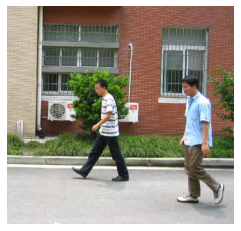

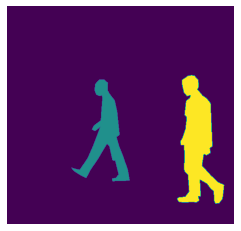

In [3]:
# Inspect the dataset

img_path = './data/pennfudan/PennFudanPed/PNGImages/FudanPed00001.png'
mask_path = './data/pennfudan/PennFudanPed/PedMasks/FudanPed00001_mask.png'
img = Image.open(img_path)
img_mask = Image.open(mask_path)

#Don't show axis
plt.axis('off')
#show the image and mask
plt.imshow(img)
plt.show()
plt.axis('off')
plt.imshow(img_mask)
plt.show()              

In [4]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch


class PennFudanDataset(Dataset):
    def __init__(self, root_dir, transforms) -> None:
        super().__init__()
        self.root = root_dir
        self.transforms = transforms
        self.imgs_names = sorted(os.listdir(os.path.join(self.root, "PNGImages")))
        self.masks_names = sorted(os.listdir(os.path.join(self.root, "PedMasks")))

    def __getitem__(self, index):
        img_path = os.path.join(self.root, "PNGImages", self.imgs_names[index])
        mask_path = os.path.join(self.root, "PedMasks", self.masks_names[index])
        img = Image.open(img_path)
        mask = np.array(Image.open(mask_path))

        object_ids = np.unique(mask)[1:]
        num_objs = len(object_ids)
        masks = (mask == object_ids[:, None, None]) #Generate a matrix of binary masks, one for each mask
        boxes = self.generate_bounding_boxes(masks)

        labels = torch.ones((num_objs,), dtype=torch.int64) # for 2 objects: [1,1] beacuse there is only one class
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64) # suppose all instances are not crowd
        boxes_pt = torch.as_tensor(boxes, dtype=torch.float32)
        masks_pt = torch.as_tensor(masks, dtype=torch.uint8)
        image_id = torch.tensor([index])
        areas = (boxes_pt[:, 3] - boxes_pt[:, 1]) * (boxes_pt[:, 2] - boxes_pt[:, 0])

        target = {}
        target["boxes"] = boxes_pt
        target["labels"] = labels
        target["masks"] = masks_pt
        target["image_id"] = image_id
        target["area"] = areas
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def generate_bounding_boxes(self, masks):
        num_objects = masks.shape[0]
        boxes = []
        for i in range(num_objects):
            y_coord, x_coord = np.where(masks[i])
            x_min = np.min(x_coord)
            x_max = np.max(x_coord)
            y_min = np.min(y_coord)
            y_max = np.max(y_coord)
            boxes.append([x_min, y_min, x_max, y_max])  
        return boxes      

    def __len__(self):
        return len(self.imgs_names)       

root_dir = './data/pennfudan/PennFudanPed'

        

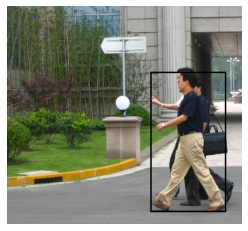

In [5]:
ds = PennFudanDataset(root_dir, None)
img, target = ds[2]
plot_boxes(img, target["boxes"])


#### Using a pretrained model for object detection

In [6]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

In [7]:
transforms = FasterRCNN_ResNet50_FPN_Weights.DEFAULT.transforms()

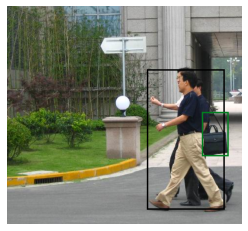

In [8]:
img_proc = transforms(img)
model.eval()
target = model([img_proc])
boxes_to_plot = target[0]['boxes'][:2]
plot_boxes(img, boxes_to_plot)

#### Define a model for fine tuning in object detection and segmentation

In [9]:
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor, MaskRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model_for_segmentation(num_classes):
    model = maskrcnn_resnet50_fpn(weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT)
    
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels

    hidden_layer = 256
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)


    return model

In [10]:
model = get_model_for_segmentation(2)

In [11]:
import utils.transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)    

In [12]:
from utils import utils
dataset = PennFudanDataset(root_dir, get_transform(train=True))
train_dataloader = DataLoader(dataset, batch_size=2, shuffle=False, num_workers=20, collate_fn=utils.collate_fn)

images, targets = next(iter(train_dataloader))

In [13]:
images2 = list(images)
targets2 = list(targets)

In [14]:
some_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

In [15]:
some_model.train()
some_model(images2, targets2)

{'loss_classifier': tensor(0.0344, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.0203, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.0027, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0009, grad_fn=<DivBackward0>)}

In [16]:
some_model.eval()
results = some_model(images2)

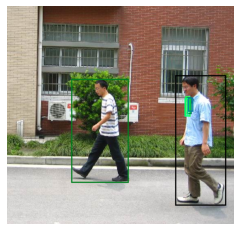

In [17]:
from torchvision.transforms.functional import to_pil_image
pil_image = to_pil_image(images2[0])
plot_boxes(pil_image, results[0]['boxes'][:6])

In [18]:
results[0]['boxes'][:10]

tensor([[414.7531, 170.6683, 539.0870, 490.2655],
        [158.7517, 179.7242, 299.6998, 434.5790],
        [439.7079, 222.5311, 451.6750, 271.7343],
        [443.9064, 224.0369, 454.1481, 265.3147],
        [437.7879, 226.3376, 446.2991, 271.4062],
        [446.5638, 225.4127, 458.3145, 259.6791]], grad_fn=<SliceBackward0>)

In [25]:
from torch.utils.data import random_split, Subset, DataLoader
from torch import Generator


def base_dataset(train):
    return PennFudanDataset('./data/pennfudan/PennFudanPed/', get_transform(train=train))

def train_model():
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    generator = Generator().manual_seed(42)
    train_dataset = base_dataset(True)
    indices = torch.randperm(len(train_dataset), generator=generator).tolist()
    train_dataset = Subset(train_dataset, indices=indices[:136])
    test_dataset = Subset(base_dataset(False), indices=indices[136:])

    train_dataloader = DataLoader(
        train_dataset, 
        batch_size=2, 
        shuffle=True, 
        collate_fn=utils.collate_fn, 
        num_workers=20)

    test_dataloader = DataLoader(
        test_dataset, 
        batch_size=1, 
        shuffle=False, 
        collate_fn=utils.collate_fn, 
        num_workers=20)    

    model = get_model_for_segmentation(2)    

    return model

In [29]:
md = train_model()
params = list(md.parameters())
params_2 = [p for p in md.parameters() if p.requires_grad]

In [31]:
len(params_2), len(params)

(95, 95)